<h1>Import Data</h1>

In [204]:
import pandas as pd

#Load the data
tab = pd.read_csv('data_Features.csv')
tabY = pd.read_csv('data_Targets.csv')

Y=tabY[["Y1"]]

<h2>Standardize</h2>

In [205]:
from sklearn.decomposition import PCA

# Séparation des caractéristiques et de la cible
X = tab.drop(columns=['time'])  # Supposons que "time" soit inutile

# Appliquer l'ACP sur les variables corrélées
pca = PCA(n_components=1)  # Réduire à 1 composante principale
mar_features = X[['r1_MAR', 'r2_MAR', 'r3_MAR', 'r4_MAR', 'r5_MAR']]
mar_pca = pca.fit_transform(mar_features)

# Ajouter la composante principale aux données
X['MAR_PCA'] = mar_pca
X_PCA = X.drop(columns=['r1_MAR', 'r2_MAR', 'r3_MAR', 'r4_MAR', 'r5_MAR'])
X_PCA.head()

,t2m,u10,v10,SST,SIC,MAR_PCA
0,-21.926931,-0.973994,3.149094,-1.690511,90.745710,-23.046562
1,-23.696195,-6.502908,2.494894,-1.690511,88.502980,-23.046579
2,-25.644027,-3.557411,1.025486,-1.689860,88.734091,-23.046585
3,-23.566887,-1.888075,-3.486122,-1.690511,89.149576,-23.046604
4,-22.897768,-2.748844,-3.491206,-1.689860,91.613955,-23.046625


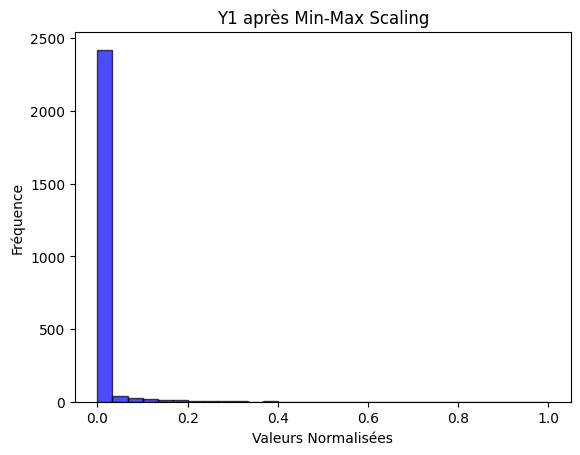

,Y1
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [206]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

scaler = MinMaxScaler()
Y_minmax = scaler.fit_transform(Y)  
Y_minmax = pd.DataFrame(Y_minmax, columns=Y.columns, index=Y.index)

X_minmax = scaler.fit_transform(X_PCA)
X_minmax = pd.DataFrame(X_minmax, columns=X_PCA.columns, index=X_PCA.index)

# Visualisation
plt.hist(Y_minmax, bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.title("Y1 après Min-Max Scaling")
plt.xlabel("Valeurs Normalisées")
plt.ylabel("Fréquence")
plt.show()
Y_minmax.head()

In [207]:
# X with most interesting features
X_final = X_minmax[['MAR_PCA', 't2m', 'u10']]

Y_minmax_copy=Y_minmax

# Y into binary variable
Y_minmax['Y1'] = (Y_minmax['Y1'] > 0).astype(int)

# Split data into test and train dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, Y_minmax, test_size=0.2, random_state=42)

In [208]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

# Entraîner le modèle final Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Prédictions
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]

# Évaluation des performances
print("Rapport de Classification - Modèle Final (Random Forest) :")
print(classification_report(y_test, y_pred))

# Calculer l'AUC-ROC
roc_auc = roc_auc_score(y_test, y_proba)
print(f"AUC-ROC: {roc_auc:.4f}")

c:\Users\yangc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Rapport de Classification - Modèle Final (Random Forest) :
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       458
           1       0.76      0.57      0.65        54

    accuracy                           0.94       512
   macro avg       0.85      0.78      0.81       512
weighted avg       0.93      0.94      0.93       512

AUC-ROC: 0.8550


In [209]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
                                                    
# Liste des seuils à tester
thresholds = np.linspace(0.1, 0.9, 9)  # Seuils de 0.1 à 0.9
metrics = []

# Tester chaque seuil
for threshold in thresholds:
    # Prédictions binaires basées sur le seuil
    y_pred_threshold = (y_proba > threshold).astype(int)
    
    # Calcul des métriques
    precision = precision_score(y_test, y_pred_threshold)
    recall = recall_score(y_test, y_pred_threshold)
    f1 = f1_score(y_test, y_pred_threshold)
    
    # Stocker les résultats
    metrics.append({
        'Threshold': threshold,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

In [210]:
import pandas as pd

# Convertir les résultats en DataFrame
metrics_df = pd.DataFrame(metrics)

# Afficher les résultats
print(metrics_df)

# Identifier le meilleur seuil selon une métrique (par exemple, F1-Score)
best_threshold = metrics_df.loc[metrics_df['Recall'].idxmax(), 'Threshold']
print(f"Meilleur seuil basé sur le F1-Score: {best_threshold:.2f}")

   Threshold  Precision    Recall  F1-Score
0        0.1   0.422680  0.759259  0.543046
1        0.2   0.569231  0.685185  0.621849
2        0.3   0.660377  0.648148  0.654206
3        0.4   0.727273  0.592593  0.653061
4        0.5   0.756098  0.574074  0.652632
5        0.6   0.783784  0.537037  0.637363
6        0.7   0.838710  0.481481  0.611765
7        0.8   0.846154  0.407407  0.550000
8        0.9   0.894737  0.314815  0.465753
Meilleur seuil basé sur le F1-Score: 0.10


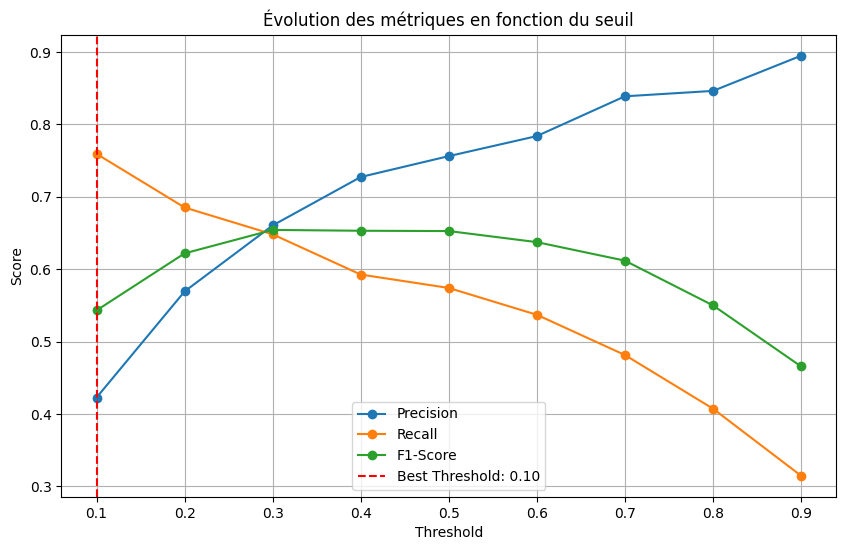

In [211]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Threshold'], metrics_df['Precision'], label='Precision', marker='o')
plt.plot(metrics_df['Threshold'], metrics_df['Recall'], label='Recall', marker='o')
plt.plot(metrics_df['Threshold'], metrics_df['F1-Score'], label='F1-Score', marker='o')
plt.axvline(best_threshold, color='red', linestyle='--', label=f"Best Threshold: {best_threshold:.2f}")
plt.title("Évolution des métriques en fonction du seuil")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.grid()
plt.show()

<h2>Random Forest with Best threshold</h2>

In [212]:
# Y into binary variable
Y_minmax_copy['Y1'] = (Y_minmax_copy['Y1'] > best_threshold).astype(int)

# Split data into test and train dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, Y_minmax, test_size=0.2, random_state=42)

In [213]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

# Entraîner le modèle final Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Prédictions
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]

# Évaluation des performances
print("Rapport de Classification - Modèle Final (Random Forest) :")
print(classification_report(y_test, y_pred))

# Calculer l'AUC-ROC
roc_auc = roc_auc_score(y_test, y_proba)
print(f"AUC-ROC: {roc_auc:.4f}")

c:\Users\yangc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Rapport de Classification - Modèle Final (Random Forest) :
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       458
           1       0.76      0.57      0.65        54

    accuracy                           0.94       512
   macro avg       0.85      0.78      0.81       512
weighted avg       0.93      0.94      0.93       512

AUC-ROC: 0.8550


<h2>Bagging</h2>

In [214]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
from sklearn.ensemble import BaggingClassifier

treemod = tree.DecisionTreeClassifier()

bagmod=BaggingClassifier(estimator=treemod, n_estimators=10, random_state=0)
treemodfit=treemod.fit(X_train, y_train)
bagmodfit=bagmod.fit(X_train, y_train)

pY_train=bagmodfit.predict_proba(X_test)

#Score and decision on the training set
predxclass=np.argmax(pY_train,axis=1)

c:\Users\yangc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_bagging.py:888: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.94
Precision: 0.74
Recall: 0.59
F1-Score: 0.66

Rapport de Classification:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       458
           1       0.74      0.59      0.66        54

    accuracy                           0.94       512
   macro avg       0.85      0.78      0.81       512
weighted avg       0.93      0.94      0.93       512



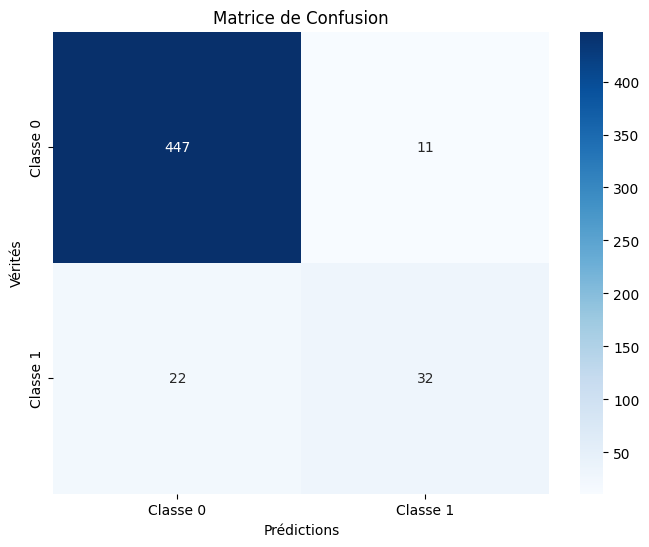

In [215]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Prédictions
# Note: `predict_proba` renvoie des probabilités, mais pour évaluer les métriques, nous devons utiliser `predict`
y_pred = bagmodfit.predict(X_test)

# Évaluer les métriques principales
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Affichage des résultats
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# Affichage du rapport de classification
print("\nRapport de Classification:")
print(classification_report(y_test, y_pred))

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualisation de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Classe 0", "Classe 1"], yticklabels=["Classe 0", "Classe 1"])
plt.title("Matrice de Confusion")
plt.xlabel("Prédictions")
plt.ylabel("Vérités")
plt.show()

<h2>Adaboost</h2>

c:\Users\yangc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\yangc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       458
           1       0.75      0.56      0.64        54

    accuracy                           0.93       512
   macro avg       0.85      0.77      0.80       512
weighted avg       0.93      0.93      0.93       512

Accuracy: 0.934
Precision: 0.750
Recall: 0.556
F1-Score: 0.638
ROC AUC Score: 0.849


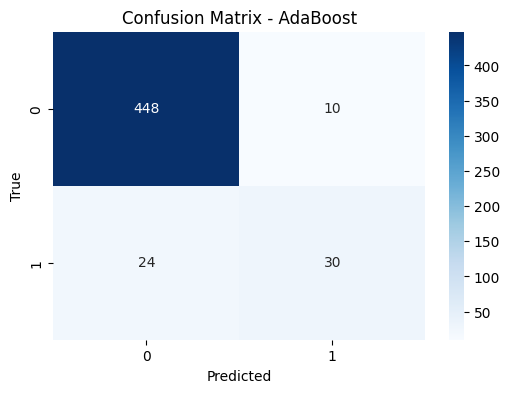

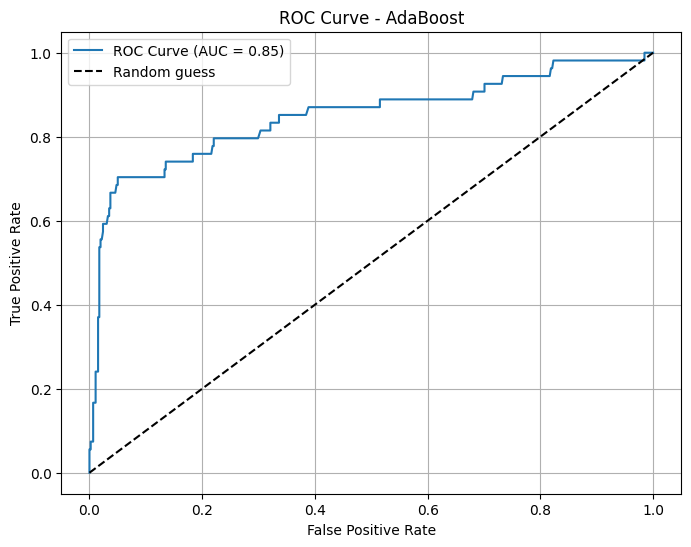

In [216]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.metrics import roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Créer un modèle AdaBoost
adaboost_model = AdaBoostClassifier(n_estimators=100, random_state=0)

# Entraîner le modèle
adaboost_model.fit(X_train, y_train)

# Prédictions (classes et probabilités)
y_pred = adaboost_model.predict(X_test)  # Classe prédite
y_proba = adaboost_model.predict_proba(X_test)[:, 1]  # Probabilités pour la classe positive

# Évaluation des métriques
# Accuracy
acc = accuracy_score(y_test, y_pred)

# Precision, Recall, F1-Score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_proba)

# Afficher les résultats
print("Classification Report:\n")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {acc:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}")
print(f"ROC AUC Score: {roc_auc:.3f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - AdaBoost")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - AdaBoost")
plt.legend()
plt.grid()
plt.show()

<h2>Extra Tree</h2>

c:\Users\yangc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       458
           1       0.72      0.54      0.62        54

    accuracy                           0.93       512
   macro avg       0.84      0.76      0.79       512
weighted avg       0.92      0.93      0.92       512

Accuracy: 0.930
Precision: 0.725
Recall: 0.537
F1-Score: 0.617
ROC AUC Score: 0.861


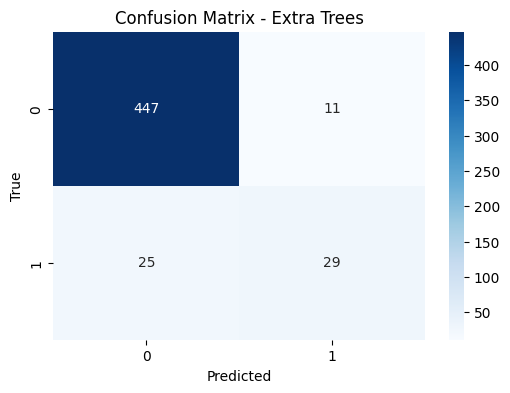

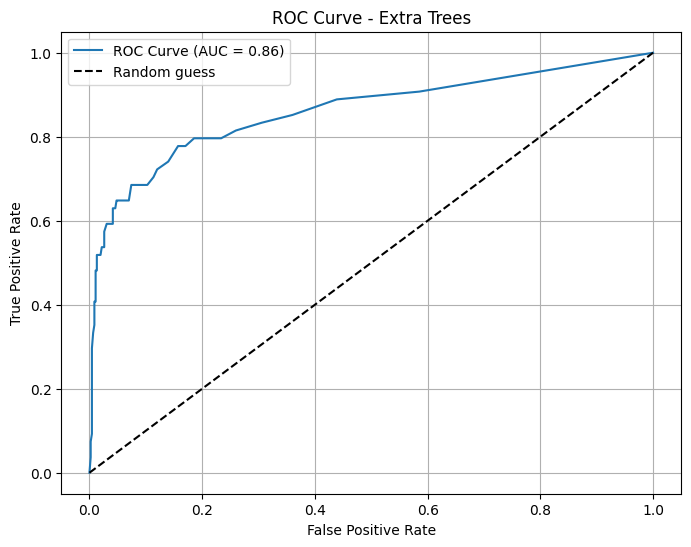

In [217]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.metrics import roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Créer un modèle Extra Trees
extra_trees_model = ExtraTreesClassifier(n_estimators=100, random_state=42)

# Entraîner le modèle sur les données
extra_trees_model.fit(X_train, y_train)

# Prédictions (classes et probabilités)
y_pred = extra_trees_model.predict(X_test)  # Classe prédite
y_proba = extra_trees_model.predict_proba(X_test)[:, 1]  # Probabilités pour la classe positive

# Évaluation des métriques
# Accuracy
acc = accuracy_score(y_test, y_pred)

# Precision, Recall, F1-Score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_proba)

# Afficher les résultats
print("Classification Report:\n")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {acc:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}")
print(f"ROC AUC Score: {roc_auc:.3f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Extra Trees")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Extra Trees")
plt.legend()
plt.grid()
plt.show()